<a href="https://colab.research.google.com/github/veliona/music-streaming-platforms-NLP/blob/master/Spotify_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import defaultdict
import json
import pandas as pd
from datetime import datetime
import requests
import csv

In [2]:
from google.colab import drive
import io
import sys
import os
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
sys.path.append('/content/gdrive/My Drive/Studia')
os.listdir('/content/gdrive/My Drive/Studia')

['Głos 008.m4a',
 'Głos 009.m4a',
 'Statystyka (1)',
 'MIG1.m4a',
 'LUMINO.xlsx',
 'Marketing',
 'E-sylabusy',
 'IT',
 'ETIX',
 'Statystyka',
 'Zarządzanie',
 'Lista nr 1.xls',
 '~$Etix.docx',
 '~$ix-procesy.docx',
 'Case studies book.pdf',
 'MSG',
 'podanie-o-urlop-dziekanski (1).doc',
 'polish_sentiment_dataset.csv',
 'r-spotify-Hot 04-23-2020.csv',
 'df_google_play_spotify.csv',
 'google_play_spotify.csv',
 'google_play_spotify.gsheet',
 'mallet-2.0.8.zip',
 'mallet-2.0.8.zip (Unzipped Files)']

## Scrap Spotify Google Play reviews

In [0]:
# ! pip install google_play_scraper

In [0]:
# from google_play_scraper import Sort, reviews
# import pandas as pd

# df_google_play_spotify = pd.DataFrame([])

# def dump(obj):
#    for attr in dir(obj):
#        if hasattr( obj, attr ):
#            print( "obj.%s = %s" % (attr, getattr(obj, attr)))

# result, continuation_token = reviews(
#     'com.spotify.music',
#     lang='pl', # defaults to 'en'
#     country='pl', # defaults to 'us'
#     sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
#     count=10, # defaults to 100
#     filter_score_with=None # defaults to None(means all score)
# )
# df_partial_reviews = pd.DataFrame(result)
# df_google_play_spotify = pd.concat([df_google_play_spotify, df_partial_reviews], ignore_index=True)
# print(continuation_token.token)

# e = 0
# for e in range(500):
#     e += 1
#     result, continuation_token = reviews(
#         'com.spotify.music',
#         continuation_token=continuation_token,
#         lang='pl',
#         country='pl',
#         sort=Sort.MOST_RELEVANT,
#         count=100, # defaults to 100
#     )
#     df_partial_reviews = pd.DataFrame(result)
#     df_google_play_spotify = pd.concat([df_google_play_spotify, df_partial_reviews], ignore_index=True)
#     print(continuation_token.token)
#     print(len(df_google_play_spotify))

In [0]:
# while type(continuation_token.token) is type(str()):

# Spotify Reddit

In [0]:
df_spotify_hot_posts = pd.read_csv('/content/gdrive/My Drive/Studia/r-spotify-Hot 04-23-2020.csv')

In [0]:
df_spotify_hot_posts.head()

,Title,Flair,Date Created,Upvotes,Upvote Ratio,ID,Edited?,Is Locked?,NSFW?,Is Spoiler?,Stickied?,URL,Comment Count,Text
0,Update: Upcoming playlist submission changes,NaN,04-10-2020 10:10:49,91,0.92,fy3tom,False,False,False,False,True,https://www.reddit.com/r/spotify/comments/fy3t...,51,"Hello everyone,\n\nAs a new moderator for this..."
1,Playlists Megathread - Submit here your playli...,Playlist,04-12-2020 11:59:36,47,0.84,fznwiy,04-12-2020 04:13:40,False,False,False,True,https://www.reddit.com/r/spotify/comments/fznw...,539,"As mentioned previously, submission of playlis..."
2,Seems like they removed All Eyez On Me,Other,04-23-2020 18:55:21,149,0.93,g6j9fg,False,False,False,False,False,https://www.reddit.com/r/spotify/comments/g6j9...,59,I can't listen to all eyez on me from tupac an...
3,"No more 2pac on spotify. Today, spotify put an...",Complaint,04-23-2020 21:44:36,50,0.81,g6l6m4,False,False,False,False,False,https://www.reddit.com/r/spotify/comments/g6l6...,27,NaN
4,Why is spotify still alive and big if it’s rou...,Question,04-23-2020 06:54:53,295,0.95,g697xy,04-23-2020 01:09:53,False,False,False,False,https://www.reddit.com/r/spotify/comments/g697...,76,I am aware that Spotify has finally made a pro...


In [0]:
df_spotify_hot_posts['title_content'] = df_spotify_hot_posts['Title'] + df_spotify_hot_posts['Text']

In [0]:
import nltk; nltk.download('stopwords')
! pip install -U spacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

     |████████████████████████████████| 1.6MB 2.6MB/s 
     |████████████████████████████████| 552kB 12.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=83482a6b2a70ad242e46f9b2e28c333cb42f8e6f5c93c7124f29cd62a89d627a
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=612fa0299f0a88e2e580f6df3bd849f3888d4332f3cf3365eedbd82b4901bac4
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [0]:
# Convert to list
list_text = df_spotify_hot_posts.title_content.values.tolist()

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(list_text))

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['update', 'upcoming', 'playlist', 'submission', 'changeshello', 'everyone', 'as', 'new', 'moderator', 'for', 'this', 'sub', 've', 'been', 'doing', 'some', 'minor', 'adjustments', 'to', 'try', 'more', 'effectively', 'curbing', 'the', 'constant', 'submissions', 'by', 'spammers', 'one', 'of', 'the', 'things', 'which', 'had', 'come', 'up', 'and', 'was', 'also', 'noted', 'in', 'the', 'thread', 'about', 'problems', 'here', 'is', 'handling', 'playlist', 'submissions', 'in', 'better', 'way', 'to', 'that', 'end', 'there', 'will', 'be', 'dedicated', 'thread', 'where', 'playlists', 'will', 'have', 'to', 'be', 'submitted', 'if', 'there', 'is', 'interest', 'we', 'may', 'see', 'about', 'splitting', 'out', 'to', 'small', 'degree', 'by', 'some', 'criteria', 'such', 'as', 'genre', 'new', 'artists', 'etc', 'anticipate', 'finalizing', 'the', 'automoderator', 'rules', 'within', 'the', 'next', 'few', 'days', 'and', 'then', 'blocking', 'any', 'playlist', 'submissions', 'outside', 'of', 'the', 'designated',

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['upcoming', 'playlist', 'submission', 'changeshello', 'new', 'moderator', 'sub', 'minor', 'adjustment', 'try', 'effectively', 'curb', 'constant', 'submission', 'spammer', 'thing', 'come', 'also', 'note', 'thread', 'problem', 'handle', 'playlist', 'submission', 'well', 'way', 'end', 'dedicated', 'thread', 'playlist', 'submit', 'interest', 'may', 'see', 'splitting', 'small', 'degree', 'criterion', 'genre', 'new', 'artist', 'automoderator', 'rule', 'next', 'day', 'block', 'playlist', 'submission', 'designate', 'thread', 'would', 'also', 'like', 'standardized', 'way', 'format', 'description', 'possibly', 'require', 'tag', 'genre', 'allow', 'easy', 'search', 'personally', 'think', 'submitter', 'heavy', 'handed', 'emojis', 'title', 'idea', 'suggestion', 'area', 'let', 'know', 'thank']]


In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 4), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1)]]


In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.085*"spotify" + 0.046*"music" + 0.037*"feature" + 0.026*"know" + '
  '0.025*"would" + 0.022*"get" + 0.022*"need" + 0.020*"sometimes" + '
  '0.017*"lyric" + 0.017*"order"'),
 (1,
  '0.108*"song" + 0.052*"play" + 0.051*"artist" + 0.041*"playlist" + '
  '0.032*"album" + 0.024*"go" + 0.023*"listen" + 0.023*"make" + 0.018*"sort" + '
  '0.018*"ad"'),
 (2,
  '0.044*"put" + 0.040*"change" + 0.039*"account" + 0.034*"password" + '
  '0.031*"can" + 0.027*"open" + 0.025*"playlist" + 0.025*"people" + '
  '0.021*"friend" + 0.020*"probably"'),
 (3,
  '0.107*"song" + 0.047*"back" + 0.034*"playlist" + 0.028*"go" + 0.027*"play" '
  '+ 0.025*"add" + 0.022*"fix" + 0.022*"listen" + 0.022*"like" + '
  '0.021*"different"'),
 (4,
  '0.039*"allow" + 0.037*"next" + 0.035*"finish" + 0.029*"remember" + '
  '0.027*"send" + 0.024*"band" + 0.023*"stream" + 0.019*"couple" + '
  '0.017*"apply" + 0.016*"already"'),
 (5,
  '0.044*"playlist" + 0.033*"mix" + 0.031*"hear" + 0.030*"able" + '
  '0.030*"country" + 0

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.998772175344449

Coherence Score:  0.3483922809458543


In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.306303  0.084441       1        1  15.841595
13     0.219485 -0.153848       2        1  15.394849
0      0.136940 -0.158351       3        1   9.799237
3      0.238932  0.140163       4        1   8.645665
12     0.052132  0.115885       5        1   5.407002
2      0.020902  0.121230       6        1   4.562370
16     0.034174  0.023783       7        1   4.155786
6     -0.070813 -0.041715       8        1   3.960296
9     -0.067993 -0.079103       9        1   3.746403
11    -0.012302 -0.154729      10        1   3.545021
8     -0.109102 -0.072838      11        1   3.506572
14     0.006052 -0.079851      12        1   3.385389
7     -0.088040 -0.095925      13        1   3.276556
19    -0.068879  0.080390      14        1   2.777321
15    -0.038376 -0.078216      15        1   2.763014
5     -0.042150  0.085085      16        1   2.411294
10    -0.123233  0.081649      17        1   2.234194
18    -0.146262  0.021756      18        1   1.697382
4     -0.119022  0.057107      19        1   1.544097
17    -0.128746  0.103086      20        1   1.345960, topic_info=         Term        Freq       Total Category  logprob  loglift
110      song  347.000000  347.000000  Default  30.0000  30.0000
38   playlist  233.000000  233.000000  Default  29.0000  29.0000
208   account   89.000000   89.000000  Default  28.0000  28.0000
160   spotify  388.000000  388.000000  Default  27.0000  27.0000
4      artist  151.000000  151.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
142   finally    2.498221    5.974096  Topic20  -4.2394   3.4362
90       make    3.461694   84.358307  Topic20  -3.9132   1.1147
172       bad    2.349983   18.090410  Topic20  -4.3006   2.2671
147      keep    2.244217   41.620003  Topic20  -4.3466   1.3878
309      sign    1.760193   14.637736  Topic20  -4.5896   2.1899

[977 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
580       3  0.910711     ability
245       1  0.669879        able
245      16  0.274042        able
245      18  0.030449        able
337      14  0.890135  absolutely
...     ...       ...         ...
130      12  0.186026        year
728       6  0.836568   yesterday
295       3  0.485244         yet
295       6  0.485244         yet
1774      2  0.909158     youtube

[1257 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 14, 1, 4, 13, 3, 17, 7, 10, 12, 9, 15, 8, 20, 16, 6, 11, 19, 5, 18])

## Hyperparameters tunning

In [0]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [0]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 10
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = ['75% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=300)
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                
                pbar.update(1)
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
pbar.close()

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
100%|██████████| 300/300 [20:52<00:00,  4.18s/it]


## Final model

In [0]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=7, 
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      alpha= 0.01,
                                      eta=0.9)

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# Google Play Spotify PL



In [0]:
df_google_play_spotify = pd.read_csv('/content/gdrive/My Drive/Studia/google_play_spotify.csv')

In [5]:
df_google_play_spotify.tail()

,Unnamed: 0,Unnamed: 0.1,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
50005,50005,50005,Tetris TT,https://lh3.googleusercontent.com/-YdgjhLCHy54...,Super polecam,5,0,7.9.0.746,2017-03-16 18:21:30,NaN,NaN
50006,50006,50006,Felipe V600,https://lh3.googleusercontent.com/a-/AOh14Ggf8...,Świetna apka,5,0,7.9.0.746,2017-03-17 13:41:19,NaN,NaN
50007,50007,50007,Robert Sudomierski,https://lh3.googleusercontent.com/-2JeT7ybAoeI...,Polecam jest super,5,0,7.9.0.746,2017-03-13 15:18:18,NaN,NaN
50008,50008,50008,Marysia Kwasiborska,https://lh3.googleusercontent.com/-tRxj6jUa18U...,Super,5,0,7.9.0.746,2017-04-03 06:57:44,NaN,NaN
50009,50009,50009,Limciu,https://lh3.googleusercontent.com/a-/AOh14GiCw...,Dużo muzyk,5,0,7.9.0.746,2017-03-17 16:21:21,NaN,NaN


In [0]:
# df_google_play_spotify_pl = df_google_play_spotify['content']

In [0]:
# # NLTK Stop words
# from nltk.corpus import stopwords
# print(stopwords.fileids())
# # stop_words = stopwords.words('polish')
# # stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
! pip install stop-words
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
# ! pip3 install --upgrade gensim

In [0]:
from stop_words import get_stop_words
stop_words = get_stop_words('pl')
stop_words.extend(['spotify', 'aplikacja', 'aplikacji', 'app', 'music', 'było', 'nawet', 'wiem', 'ale', 'sie', 'tylko'])

In [0]:
# Convert to list
list_text = df_google_play_spotify.content.values.tolist()

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(list_text))

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['korzystam', 'aplikacji', 'około', 'lat', 'czego', 'prawie', 'rok', 'premium', 'nie', 'zamierzam', 'sie', 'nim', 'rozstawac', 'szkoda', 'ze', 'nie', 'wszystkie', 'piosenki', 'sa', 'dostepne', 'polsce', 'ale', 'tym', 'mozna', 'sobie', 'poradzic', 'aplikacja', 'swietna', 'brakuje', 'mi', 'niej', 'tylko', 'wbudowanych', 'tekstow_piosenek', 'jak', 'to', 'było', 'dawno', 'temu', 'stad', 'jesli', 'ta', 'opcja', 'powroci', 'moja_opinia', 'pewnoscia', 'sie', 'polepszy', 'mogłoby_byc', 'jeszcze', 'dodawanie', 'utworow', 'telefonu', 'ale', 'jest', 'na', 'komputerze', 'tez', 'jest', 'porzadku', 'chociaz', 'czesciej', 'słucham', 'telefonu']


In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['prawie', 'brakuje']]


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [0]:
# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -25.541871734829837

Coherence Score:  0.5506430492746167


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

TypeError: ignored

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
6     -0.315009+0.000000j -0.236270+0.000000j       1        1  19.634836
3     -0.152357+0.000000j  0.120620+0.000000j       2        1  14.512518
14     0.025972+0.000000j -0.010705+0.000000j       3        1  12.035489
4     -0.185249+0.000000j  0.270090+0.000000j       4        1  11.927203
19     0.023612+0.000000j -0.010339+0.000000j       5        1   6.204727
11     0.043709+0.000000j -0.011926+0.000000j       6        1   4.925196
15     0.044671+0.000000j -0.010519+0.000000j       7        1   3.920484
8      0.040995+0.000000j -0.012006+0.000000j       8        1   3.321638
9      0.043848+0.000000j -0.009980+0.000000j       9        1   3.120374
2      0.044683+0.000000j -0.010530+0.000000j      10        1   2.707078
0      0.043532+0.000000j -0.009801+0.000000j      11        1   2.524293
13     

#### Optimal number of topics

In [21]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [0]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
# corpus_path = 'transcripts' # you need to change this path to the directory containing your corpus of .txt files

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=40, step=1)

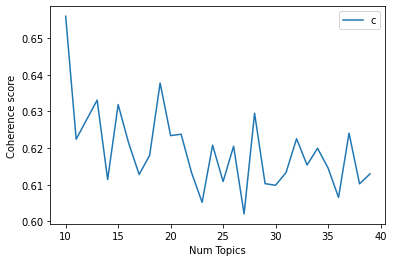

In [34]:
# Show graph
limit=40; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=27, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [0]:
# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -33.53603571389141

Coherence Score:  0.5714949202645226


In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

TypeError: ignored

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
3     -0.215711+0.000000j -0.330418+0.000000j       1        1  15.211519
16    -0.369218+0.000000j  0.202088+0.000000j       2        1  14.289963
15     0.026535+0.000000j  0.007503+0.000000j       3        1   8.554420
1     -0.019706+0.000000j  0.000029+0.000000j       4        1   6.719888
24     0.021473+0.000000j  0.007174+0.000000j       5        1   6.101035
0      0.025789+0.000000j  0.007536+0.000000j       6        1   4.811873
19     0.006487+0.000000j  0.005199+0.000000j       7        1   4.167244
17     0.028099+0.000000j  0.007529+0.000000j       8        1   3.579657
10     0.021073+0.000000j  0.007136+0.000000j       9        1   3.393109
8      0.029103+0.000000j  0.005558+0.000000j      10        1   2.706089
11     0.030531+0.000000j  0.006264+0.000000j      11        1   2.546781
7      

#### Hyperparameters tunning

In [0]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [0]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 10
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = ['75% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=300)
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                
                pbar.update(1)
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
pbar.close()

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
 28%|██▊       | 84/300 [2:29:50<6:03:54, 101.09s/it]

## Final model

In [0]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=7, 
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      alpha= 0.01,
                                      eta=0.9)

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

## Worldcloud

In [0]:
! pip install wordcloud

In [0]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
# print(type(data_lemmatized))
# print(data_lemmatized[0])

<class 'list'>
['aplikacji', 'prawie', 'aplikacja', 'swietna', 'brakuje', 'było']


In [0]:
data_string = ''

for each_list in data_lemmatized:
  for each_word in each_list:
    data_string += ' ' + str(each_word)

print(data_string)

 prawie brakuje prawie aktualizacji problem pojawia telefon stand line zadziałał sterowaniem odtwarzaniem wczesniej smigało odinstalowuje dostep online offline muzyka podglad odczeka chwili uciazliwe poziomu playlisty mimo pobrane podłaczony internetu ciagły gdy zakonczy dziwny ciekawych cyfry smieszniejsze typu internet internetu prawie internetu teraz wyłaczyła roznych utwory aktualizacji dodawały dawna przycisk instrukcji idzie dodatkiem przyczyn problem dziwny nastepnym muzyki ciagłe interfejsie znikajacy panel najgorsze must_have premium ok dosyc utworow dobry inter mozna polecam reaguje piosenek utworow duzy natretna online inaczej działa przepadna gdzie ogolna tonow program premium schowka mały pewna utwor razu mozna poniewaz problemu strone odsłuchac super niedawna opcji ograniczeniem brakiem absurd producent premium interetu paru piosenkach naprawcie upierdliwe znikneła licze aktualizacji internet update zatrzymuje srednio brakuje problemu oczekuje byłaby super jakie gry raz w

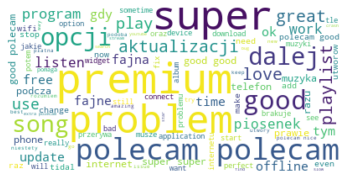

In [0]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data_string)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Text collocation

https://www.geeksforgeeks.org/nlp-word-collocations/

In [0]:
import nltk
nltk.download('webtext')
from nltk.corpus import webtext
# use to find bigrams, which are pairs of words 
from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import *

[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


In [0]:
df_google_play_spotify['content']

0        Korzystam z aplikacji około 2 lat, z czego pra...
1        Używam aplikacji spotify od prawie 3 lat i nie...
2        Aplikacja spełnia swoje zadanie. Jest prosta w...
3        Bardzo fajna aplikacja, piosenki z całego świa...
4        Niestety, coś poszło nie tak. Po ostatniej akt...
                               ...                        
50005                                        Super polecam
50006                                         Świetna apka
50007                                   Polecam jest super
50008                                                Super
50009                                           Dużo muzyk
Name: content, Length: 50010, dtype: object

In [0]:
df_google_play_spotify['content'] = df_google_play_spotify['content'].astype(str)

In [0]:
merged_reviews = []
for review in df_google_play_spotify['content'][:1000]:
  review_str = review.split(' ')
  for word in review_str:
    merged_reviews.append(word)

['Korzystam', 'z', 'aplikacji', 'około', '2', 'lat,', 'z', 'czego', 'prawie', 'rok', 'premium', 'i', 'nie', 'zamierzam', 'się', 'z', 'nim', 'rozstawać.', 'Szkoda,', 'że', 'nie', 'wszystkie', 'piosenki', 'są', 'dostępne', 'w', 'Polsce,', 'ale', 'i', 'z', 'tym', 'można', 'sobie', 'poradzić.', 'Aplikacja', 'świetna,', 'brakuje', 'mi', 'w', 'niej', 'tylko', 'wbudowanych', 'tekstów', 'piosenek,', 'jak', 'to', 'było', 'dawno', 'temu', '(stąd', '4*).', 'Jeśli', 'ta', 'opcja', 'powróci,', 'moja', 'opinia', 'z', 'pewnością', 'się', 'polepszy.', 'Mogłoby', 'być', 'jeszcze', 'dodawanie', 'utworów', 'z', 'telefonu,', 'ale', 'jest', 'na', 'komputerze', 'i', 'też', 'jest', 'w', 'porządku,', 'chociaż', 'częściej', 'słucham', 'z', 'telefonu.', 'Używam', 'aplikacji', 'spotify', 'od', 'prawie', '3', 'lat', 'i', 'nie', 'miałem', 'z', 'nią,', 'żadnych', 'problemów,', 'aż', 'do', 'momentu', 'wprowadzenia', 'poprzedniej', 'aktualizacji.', 'Zaczęły', 'się', 'zacinać', 'piosenki,', 'nie', 'ważne', 'czy', 'pob

In [0]:
! pip install stop-words
from stop_words import get_stop_words
stop_words = get_stop_words('pl')
stop_words.extend(['spotify', 'aplikacja', 'aplikacji', 'app', 'music', 'było', 'nawet', 'wiem', 'ale', 'sie', 'tylko'])

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=ad0aea1df2da4d2ea72fc46cc30993fd279d023f979f2903cf36abf08590ebd5
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
# Loading the data  
words = [w.lower() for w in merged_reviews]
# stopset = set(stopwords.words('english')) 
filter_stops = lambda w: len(w) < 3 or w in stop_words 
  
biagram_collocation.apply_word_filter(filter_stops) 
biagram_collocation = BigramCollocationFinder.from_words(words)
biagram_collocation.apply_freq_filter(3)
# biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 15)
for i in biagram_collocation.score_ngrams(bigram_measures.likelihood_ratio):
    print (i)

In [0]:
## Trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(words)
# only trigrams that appear 3+ times
finder.apply_freq_filter(3)
# return the 10 n-grams with the highest PMI
# print (finder.nbest(trigram_measures.likelihood_ratio, 10))
for i in finder.score_ngrams(trigram_measures.likelihood_ratio):
    print (i)

In [0]:
# ## Trigrams
# trigram_measures = nltk.collocations.TrigramAssocMeasures()
# # Ngrams with 'creature' as a member
# creature_filter = lambda *w: 'kids' not in w
# finder = TrigramCollocationFinder.from_words(
#    filtered_sentences)
# # only trigrams that appear 3+ times
# finder.apply_freq_filter(3)
# # only trigrams that contain 'creature'
# finder.apply_ngram_filter(creature_filter)
# # return the 10 n-grams with the highest PMI
# # print (finder.nbest(trigram_measures.likelihood_ratio, 10))
# for i in finder.score_ngrams(trigram_measures.likelihood_ratio):
#     print (i)

## Sentiment analysis

### Pretrained TextBlob

In [0]:
! pip install -U textblob

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)


In [0]:
from textblob import TextBlob

In [0]:
def sentimentEvaluation(t):
   
    blob = TextBlob(t)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return "positive"
    elif sentiment < 0:
        return "negative"
    else:
        return "neutral"

In [0]:
df_google_play_spotify['content_en'] = df_google_play_spotify['content']

In [0]:
df_google_play_spotify['sentiment'] = df_google_play_spotify['content'].map(lambda tx: sentimentEvaluation(tx))

### Word2vec and keras
https://ermlab.com/en/blog/nlp/polish-sentiment-analysis-using-keras-and-word2vec/

In [0]:
! pip install livelossplot

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from livelossplot import PlotLossesKeras
np.random.seed(7)
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
import h5py
from time import time

Using TensorFlow backend.


In [0]:
df_google_play_spotify.head(1)

,Unnamed: 0,Unnamed: 0.1,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,0,0,Saph,https://lh3.googleusercontent.com/a-/AOh14Ggma...,"Korzystam z aplikacji około 2 lat, z czego pra...",4,792,8.5.1.734,2019-05-04 08:16:04,NaN,NaN


In [0]:
test = pd.read_csv('/content/gdrive/My Drive/Studia/polish_sentiment_dataset.csv')

In [0]:
# # Delete unused column
# del dataset['length']
 
# # Delete All NaN values from columns=['description','rate']
# dataset = dataset[dataset['description'].notnull() &amp; dataset['rate'].notnull()]
 
# We set all strings as lower case letters
df_google_play_spotify['content_lower'] = df_google_play_spotify['content'].str.lower()

In [0]:
X = dataset['description']
y = dataset['rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)